# Importation librairies

In [225]:
# things we need for NLP
import nltk
#from nltk.stem.lancaster import LancasterStemmer
#stemmer = LancasterStemmer()
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [226]:
# things we need for Tensorflow
import numpy as np
import keras
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
from nltk import word_tokenize

# Nettoyage texte (stopwords, stemming) et vectorisation

## Code stemming, stop words et vectorisation

In [227]:
# import our chat-bot intents file
import json

def import_corpus(jsonfile): #permet d'importer le corpus
    try:
        with open(jsonfile, encoding='utf-8') as json_data:
            intents = json.load(json_data)
        return intents

    except OSError as err:
        print("OS error: {0}".format(err))
    except ValueError:
        print("Your .json is wrong, look at https://jsonlint.com/")
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise
        
corpus = import_corpus('intents.json')
#corpus

In [253]:
from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()


def clean_text(phrase): #fait du french stemming et du stop words sur une phrase
    try:
        stop_words=stopwords.words("French")
        stop_words.append("'")
        stop_words.append(".")
        stop_words.append("?")
        stop_words.append(",")
        stop_words.append('"')
        
        
        filtered_sentence=[]

        #enlever les stop words
        for mot in nltk.word_tokenize((phrase.lower())):
                    
                    #print(mot)
                    if mot not in stop_words:
                        filtered_sentence.append(mot)
        #print(filtered_sentence)

        #stemming en français
        stemmed = [stemmer.stem(i) for i in filtered_sentence]

        return stemmed
    
    except:
        print("stemming et stop_words n'ont pas fonctionnés")
    
clean_text("J'aime le ' chocolat et je suis content de tout. ?")

["j'aim", 'chocolat', 'content', 'tout']

In [254]:
from nltk.corpus import stopwords

def extraction_data_X_y(jsonfile): #permet d'obtenir les patterns (X_text) et les tags (y_text)
    corpus = import_corpus(jsonfile)
    
    X_texte = []
    y_texte = []

    try :
        for doc in corpus['intents']: #'intents
            #print(doc['tag']) #obtenir chaque tag
            for p in doc['patterns']: #'patterns'
                #print(p) #obtenir chaque phrase/patterns par tags 
                
                filtered_phrase = clean_text(p)
                
                X_texte.append(" ".join(filtered_phrase))

                y_texte.append(doc['tag']) 
                #y_texte.append(doc['tag']) #on rajoute un 2e même tag car on double le dataset
        return X_texte,y_texte
    except:
        print("l'extraction des patterns et tags n'a pas fonctionnée, allez voir la fonction extraction data_X_y")
X_text = []
y_text = []
X_text,y_text = extraction_data_X_y('intents.json')

In [255]:
#y_text

In [256]:
def vectorizer(text_to_vect):
    cv = CountVectorizer()
    
    vect = cv.fit_transform(text_to_vect)
    vect = vect.toarray()
    
    #for i in range (len(vect)):
        #print(vect[i])
        #print(text_to_vect[i])
    
    return vect 

#vectorizer(X_text)

## Debuggage
**Voici le format des données après stemming, stop words et vectorisation**

In [282]:
cv = CountVectorizer()
#vect = cv.fit_transform

data = {'Pattern':X_text,"Pattern_fit_transform":cv.fit_transform(X_text), 'tag':y_text, "tag_fit_transform": cv.fit_transform(y_text)}  

df = pd.DataFrame(data)
df[:][0:10]
#on observe avant vectorisation que chaque mot est transformé (exemple : salut correspond à (0,184), tous correspond à (0,205))

,Pattern,Pattern_fit_transform,tag,tag_fit_transform
0,salut,"(0, 184)\t1",bienvenue,"(0, 0)\t1"
1,salut tous,"(0, 184)\t1\n (0, 205)\t1",bienvenue,"(0, 0)\t1"
2,tous,"(0, 205)\t1",bienvenue,"(0, 0)\t1"
3,bonjour,"(0, 27)\t1",bienvenue,"(0, 0)\t1"
4,coucou,"(0, 56)\t1",bienvenue,"(0, 0)\t1"
5,comment ca-v,"(0, 50)\t1\n (0, 32)\t1",bienvenue,"(0, 0)\t1"
6,recherch l'aid,"(0, 172)\t1\n (0, 7)\t1",bienvenue,"(0, 0)\t1"
7,oyez oyez,"(0, 140)\t2",bienvenue,"(0, 0)\t1"
8,hey,"(0, 99)\t1",bienvenue,"(0, 0)\t1"
9,pourquoi ’ isen,"(0, 156)\t1\n (0, 108)\t1",raison_isen,"(0, 13)\t1"


In [258]:
cv = CountVectorizer()
    
vect = cv.fit_transform(X_text)
vect = vect.toarray()
pd.DataFrame(vect)
#on observe qu'il y a 227 mots possibles (index 0 à 226) sur 201 patterns (index 0 à 200)

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


---

---

# Preprocessing

## Code

---

## Code Enrichissement de données sur les données d'entrainements - Data Augmentation

**PISTE D'AMELIORATION - ENRICHISSEMENT DE DONNEES SUR LES DONNEES D'ENTRAINEMENTS ET REGARDER VIDEO PROF ANALYSE SENTIMENTS**


In [259]:
import nlpaug

In [260]:
from nltk.corpus import wordnet
from collections import OrderedDict
from deep_translator import LingueeTranslator #A ne pas utiliser car api plante parfois par prblm de connexion
from deep_translator import GoogleTranslator
to_translate = 'I want to translate this text'
translated = GoogleTranslator(source='auto', target='de').translate(to_translate)
translated

'Ich möchte diesen Text übersetzen'

In [261]:
def find_synonyms(word):
    translated_word = GoogleTranslator(source='fr', target='en').translate(word)
    
    synonyms = []
    for synset in wordnet.synsets(translated_word):
        for syn in synset.lemma_names():
            synonyms.append(GoogleTranslator(source='en', target='fr').translate(syn))
            #print(syn,"sa traduction en français",GoogleTranslator(source='en', target='fr').translate(syn))
            
    # using this to drop duplicates while maintaining word order (closest synonyms comes first)
    synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
    return list(OrderedDict.fromkeys(synonyms)) #synonyms #synonyms_without_duplicates

In [262]:
find_synonyms("like")

['aimer',
 'le_comme',
 'les goûts de',
 'acabit',
 'souhaiter',
 'se soucier',
 'similaire',
 'même',
 'ressemblent',
 'comparable',
 'correspondant']

In [269]:
from nltk import word_tokenize
def create_set_of_new_sentences(sentence, max_syn_per_word = 6, nbr_new_sentences = 1): #nbr_new_sentences est le nombre de "nouvelle" phrase crée par phrase, si =1 on va doubler le dataset par exemple
    try:
        new_sentences = []
        for word in nltk.word_tokenize(sentence):
            #print("\n")
            if len(word)<=3 : continue #les petits mots ont souvent des erreurs en synonymes
            for synonym in find_synonyms(word)[0:max_syn_per_word]:
                
                #print(synonym, word)
                synonym = synonym.replace('_', ' ') #restore space character
                new_sentence = sentence.replace(word,synonym)
                new_sentences.append(new_sentence)
        return new_sentences# [1:nbr_new_sentences+1] #le premier correspond à la phrase initiale
    except:
        print("Peut être que votre phrase n'est pas dans la bonne langue (Français) ou que vous n'avez rien mis en entrée de la fonction")

In [270]:
#def data_augmentation(X_text, nbr_new_sentences = 1):
    

In [272]:
phrase = "Quelles sont les certifications d’Yncréa ?"

new_sentences = create_set_of_new_sentences(phrase)

for new_phrase in new_sentences:
    print(new_phrase)
    #print(clean_text(new_phrase))

Quelles sont les certifications d’Yncréa ?
Quelles ar les certifications d’Yncréa ?
Quelles être les certifications d’Yncréa ?
Quelles exister les certifications d’Yncréa ?
Quelles égal les certifications d’Yncréa ?
Quelles constituer les certifications d’Yncréa ?
Quelles sont les certificat d’Yncréa ?
Quelles sont les certification d’Yncréa ?
Quelles sont les justificatif d’Yncréa ?
Quelles sont les identifiants d’Yncréa ?
Quelles sont les Sécurité d’Yncréa ?


In [268]:
X_text,y_text = extraction_data_X_y('intents.json')
X_text

['salut',
 'salut tous',
 'tous',
 'bonjour',
 'coucou',
 'comment ca-v',
 "recherch l'aid",
 'oyez oyez',
 'hey',
 'pourquoi ’ isen',
 '’ quoi différent autr écol ’ ingénieur',
 'quel différent autr écol ’ ingénieur',
 'différent autr écol ingénieur',
 "quoi l'isen meilleur",
 "chois l'isen",
 "quel avantag offert l'isen",
 "qu'offr l'isen term d'enseign",
 "quel perform peut-on retrouv l'isen",
 '’ quoi ’ isen',
 'combien ’ anné déroul ’ isen',
 '’ ’ isen',
 '’ quoi cursus ’ écol',
 "combien d'ann d'étud post bac",
 "peut-on integr l'écol apres bac",
 "comment foncion l'isen",
 "comment est-on form l'isen",
 'quel différent possibil suiv profil',
 "quel enseign l'isen",
 '’ quoi yncré ouest',
 'combien a ’ ’ écol ’ ouest',
 'quel campus ’ isen ouest',
 'brest , caen , nant ren',
 "où peut-on étudi l'isen",
 "quel centr format l'isen",
 "quel localis l'isen",
 'quel certif ’ yncré',
 '’ isen est-il sous contrat minister ’ enseign supérieur recherch',
 '’ isen est-il sous contrat mesr'

In [ ]:
X_text_,y_text = extraction_data_X_y('intents.json')


In [177]:
stop_words=stopwords.words("French")
stop_words.append("'")
stop_words.append(".")
stop_words.append("?")


In [181]:
new_sentences = create_set_of_new_sentences("En combien d’années se déroule l’ISEN ?")
#print(new_sentences)

nbr
for sentence in new_sentences:
    print(sentence)
    
    print(clean_text(sentence))
    print("\n")

En combien d’vieillesse se déroule l’ISEN ?
['combien', '’', 'vieilless', 'déroul', '’', 'isen']


En combien d’années se déroule l’ISEN ?
['combien', '’', 'anné', 'déroul', '’', 'isen']


En combien d’âge se déroule l’ISEN ?
['combien', '’', 'âge', 'déroul', '’', 'isen']


En combien d’champ se déroule l’ISEN ?
['combien', '’', 'champ', 'déroul', '’', 'isen']


En combien d’geezerhood se déroule l’ISEN ?
['combien', '’', 'geezerhood', 'déroul', '’', 'isen']


En combien d’longue durée se déroule l’ISEN ?
['combien', '’', 'longu', 'dur', 'déroul', '’', 'isen']


En combien d’années se fleur l’ISEN ?
['combien', '’', 'anné', 'fleur', '’', 'isen']


En combien d’années se s'épanouir l’ISEN ?
['combien', '’', 'anné', "s'épanou", '’', 'isen']


En combien d’années se fleurir forth l’ISEN ?
['combien', '’', 'anné', 'fleur', 'forth', '’', 'isen']


En combien d’années se se dérouler l’ISEN ?
['combien', '’', 'anné', 'déroul', '’', 'isen']


En combien d’années se s'étirer l’ISEN ?
['combien'

In [ ]:
En combien d’années se déroule l’ISEN ?

In [174]:
from deep_translator import LingueeTranslator
word = 'bon'
translated_word = LingueeTranslator(source='french', target='english').translate(word)#, return_all=True)
translated_word

RequestError: Request exception can happen due to an api connection error. Please check your connection and try again

In [133]:
to_translate = "j'aime vraiment beaucoup les pommes de terres"
translated = GoogleTranslator(source='fr', target='en').translate(to_translate)
translated = GoogleTranslator(source='en', target='fr').translate(to_translate)
translated

"j'aime vraiment beaucoup les pommes de terres"

In [132]:
https://neptune.ai/blog/data-augmentation-nlp --> à regarder : Shuffle Sentences Transform

SyntaxError: invalid syntax (Temp/ipykernel_75616/1203705234.py, line 1)

---

In [240]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def preprocessing(jsonfile):
    
    try :
        X_text,y_text = extraction_data_X_y(jsonfile)
    
        X=vectorizer(X_text)
        y=vectorizer(y_text)
        

        label_encoder_y = LabelEncoder()
        y_num = label_encoder_y.fit_transform(y_text) #[0, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]
        y_text_unique = np.unique(y_text) #['bienvenue', 'campus_ouest', 'cursus_isen', 'raison_isen']
        y_num_unique = label_encoder_y.fit_transform(y_text_unique) #[0,1,2,3]

        y_num_unique=y_num_unique.reshape((y_num_unique.shape[0],1)) #reshape pour avoir le format (nombre,1)

        y_mapping = {}
        y_mapping = dict(enumerate(y_text_unique.flatten(),0)) #{0: 'bienvenue', 1: 'campus_ouest', 2: 'cursus_isen', 3: 'raison_isen'}

        #séparation train dataset et test dataset
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
        
        print(X_train.shape)
        print(y_train.shape)
        
        return X,y,X_train,X_test,y_train,y_test
    
    except:
        print("Le preprocessing a échoué, allez voir la fonction preprocessing")
        
X, y, X_train, X_test, y_train, y_test = preprocessing('intents.json') #'intents_upgrade.json'
#X_test, y_test, X_train_test, X_test_test, y_train_test, y_test_test = preprocessing('intents_upgrade.json') #'intents_upgrade.json'

(160, 227)
(160, 26)


## Debuggage
**Données prêtes pour l'entrainement**

In [60]:
print(f"X contient {X.shape[0]} patterns contenant {X.shape[1]} mots") 
print(X.shape)
print("\nX\n",X)

X contient 201 patterns contenant 227 mots
(201, 227)

X
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [64]:
print(f"y contient le tag de {y.shape[0]} patterns soit {y.shape[1]} mots (ce sont les tag)") 
print(y.shape)
print("\ny\n",y)

y contient le tag de 201 patterns soit 26 mots (ce sont les tag)
(201, 26)

y
 [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


---
---

In [81]:
k=np.arange(0,1,0.1)
k

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Entrainement du modele

In [82]:

def train_model(X_train,y_train):
    
    model = RandomForestClassifier(n_estimators=15)
        
    model.fit(X_train,y_train)
    print("Train.score:",model.score(X_train, y_train))
    print("Test.score:",model.score(X_test, y_test))
    
    return model_entraine

## Reglage du modele

In [70]:
print(f"Voici la liste de tous les paramètres reglables du random forest : \n\n{RandomForestClassifier().get_params().keys()} \n\nPour plus d'infos, allez voir ces sites :") 

print("https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319")
print("https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn")
print("https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot")

Voici la liste de tous les paramètres reglables du random forest : 

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']) 

Pour plus d'infos, allez voir ces sites :
https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot


**Score en fonction d'un paramètre (affichage graphique)**

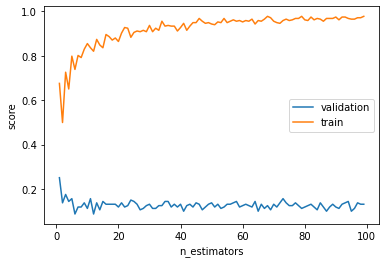

In [102]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

#model = RandomForestClassifier(criterion = 'gini', max_features = 35, n_estimators = 23, max_depth=35)
model = RandomForestClassifier(criterion = 'gini',max_features = 35, max_depth=35)
k=np.arange(0,100)
#k=np.arange(0,1,0.1)

train_score, val_score = validation_curve(model, X_train, y_train, param_name='n_estimators', param_range=k, cv=3)
# n_estimators=40 et faire varier max_features de 1 à 160 on observe une legère augmentation de score vers 70 pour froller 0.2 
# n_estimators=40 et max_features=70 et faire varier max_depth de 1 à 100, on observe un score frollant 0.2 à partir de 35, on peut laisser ce paramètre par défaut
# faire varier min_samples_leaf fait chuter le score de validation et train donc à laisser par défaut
# min_samples_split à laisser par défaut
# max_leaf_nodes à laisser par défaut
# max_samples à laisser par défaut
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

**Faire varier PLUSIEURS paramètres et on obtient le "meilleur" modèle**

ATTENTION programme peut être très long si on lance l'évaluation de plusieurs paramètres en même temps

In [76]:
from sklearn.model_selection import GridSearchCV
import time
#from sklearn.model_selection import RandomizedSearchCV

start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid = GridSearchCV(RandomForestClassifier(random_state=123, oob_score=True),param_grid, cv=3) 
#random_state=123 permet de fixer l'aléatoire, plus pratique pour nos tests
#max_features=33 vient d'un GridSearchCV avec max_features, n_estimators et max_leaf_nodes (trop long de refaire les 3)
#oob_score=True permet d'afficher certains résultats ensuite
grid.fit(X_train,y_train)

end = time.time()
print(end - start)

#permet de bloquer les NOMBREUX warnings avec oob_score
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

174.91540145874023


In [278]:
new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', max_features = 35, n_estimators = 23) #, max_depth = 35,max_leaf_nodes=35
new_model.fit(X_train,y_train)

RandomForestClassifier(max_features=35, n_estimators=23, oob_score=True,
                       random_state=123)

Matrice de confusion sur les predictions de données d'entrainement


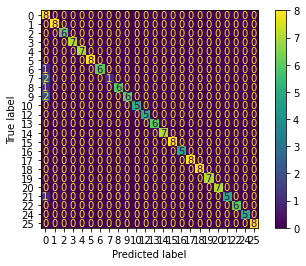

In [279]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1), new_model.predict(X_train).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


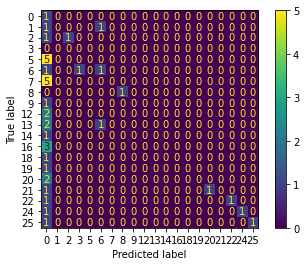

In [280]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), new_model.predict(X_test).argmax(axis=1))

## TEST avec données iris pour voir si classification bonne

In [111]:
data = pd.read_csv('iris.csv')
train_iris, test_iris = train_test_split(data, test_size = 0.4, stratify = data['species'], random_state = 42)


In [121]:
X_train_iris = train_iris[['sepal_length','sepal_width','petal_length','petal_width']]
y_train_iris = train_iris.species
X_test_iris = test_iris[['sepal_length','sepal_width','petal_length','petal_width']]
y_test_iris = test_iris.species

In [115]:
start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid_iris = GridSearchCV(RandomForestClassifier(random_state=123, oob_score=True),param_grid, cv=3) 
grid_iris.fit(X_train_iris,y_train_iris)

end = time.time()
print(end - start)

#permet de bloquer les NOMBREUX warnings avec oob_score
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

95.79060363769531


In [116]:
grid_iris.best_score_

0.9555555555555556

In [117]:
grid_iris.best_params_

{'max_leaf_nodes': 3, 'n_estimators': 3}

In [124]:
model_iris=RandomForestClassifier(random_state=123, oob_score=True,
                       max_leaf_nodes=3, n_estimators=3)
model_iris.fit(X_train_iris,y_train_iris)

RandomForestClassifier(max_leaf_nodes=3, n_estimators=3, oob_score=True,
                       random_state=123)

In [131]:
# grid_iris.oob_score_ --> ne fonctionne pas quand on l'utilise sur le resultat de gridsearchCV
model_iris.oob_score_

0.6888888888888889

Matrice de confusion sur les predictions de données d'entrainement


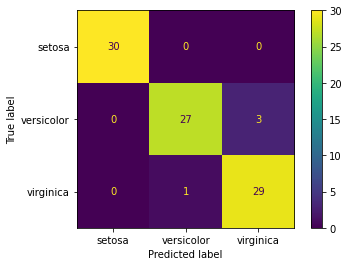

In [128]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_iris, model_iris.predict(X_train_iris))

Matrice de confusion sur les predictions de données d'entrainement


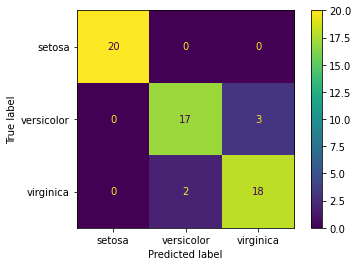

In [129]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_iris, model_iris.predict(X_test_iris))

## Evaluation du modele

grid est ici le "meilleur" modèle qui sort du gridsearchCV

In [77]:
grid.best_score_
#0.17923186344238975

0.1001630561378989

In [86]:
print(f"les meilleurs résultats sont quand on fait varier 3 paramètres : 'max_features': 33, 'max_leaf_nodes': 19, 'n_estimators': 39")
grid.best_params_

les meilleurs résultats sont quand on fait varier 3 paramètres : 'max_features': 33, 'max_leaf_nodes': 19, 'n_estimators': 39


{'max_leaf_nodes': 14, 'n_estimators': 2}

In [90]:
# new_model = grid.best_estimator_ à remettre quand on aura un meilleur gridsearchCV

new_model= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', max_features = 35, n_estimators = 23) #ce sont les meilleurs paramètres
new_model.fit(X_train,y_train)
new_model.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.14375

Matrice de confusion sur les predictions de données d'entrainement


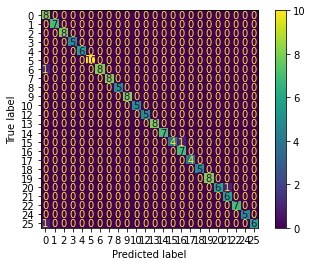

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1), new_model.predict(X_train).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


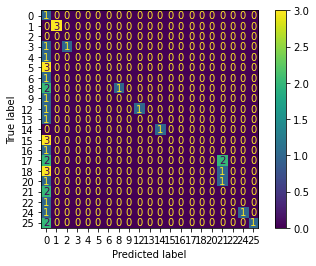

In [92]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), new_model.predict(X_test).argmax(axis=1))

# Zone de test 

---

In [104]:
new_model_test= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', n_estimators = 23) #, max_features = 35,max_depth = 34, max_leaf_nodes =19) #, max_depth = 35,max_leaf_nodes=35
new_model_test.fit(X_train,y_train)
new_model_test.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.10062893081761007

In [105]:
new_model_test= RandomForestClassifier(random_state=123, oob_score=True, criterion = 'gini', n_estimators = 23) #, max_features = 35,max_depth = 34, max_leaf_nodes =19) #, max_depth = 35,max_leaf_nodes=35
new_model_test.fit(X_train_test,y_train_test)
new_model_test.oob_score_ #permet de savoir si notre random forest a correctement généraliser (donc pas en overfitting). il faut viser 1.0

0.16964285714285715

---

In [20]:
print("new_model.score(X_train, y_train) =",new_model.score(X_train, y_train))
print("new_model.score(X_test, y_test) =",new_model.score(X_test, y_test))

new_model.score(X_train, y_train) = 0.8303571428571429
new_model.score(X_test, y_test) = 0.2857142857142857


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), new_model.predict(X_test).argmax(axis=1))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot

SyntaxError: invalid syntax (Temp/ipykernel_51032/1082711333.py, line 1)

In [ ]:
https://ichi.pro/fr/guide-du-debutant-sur-le-reglage-des-hyperparametres-de-foret-aleatoire-77596161963319
https://intellipaat.com/community/9495/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

https://www.youtube.com/watch?v=-3UBmIXGHyc&t=651s&ab_channel=AIforyou-MorganGautherot

------------------

In [ ]:
X=vectorizer(X_text)
y=vectorizer(y_text)

In [ ]:
y

In [ ]:
X


In [ ]:
#train set et test set

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder_y = LabelEncoder()

In [ ]:
y_num = label_encoder_y.fit_transform(y_text) #pour avoir la liste complète pour l'entrainement
y_num

In [ ]:
y_text

In [ ]:
y_text_unique = np.unique(y_text)
y_text_unique

In [ ]:
y_num_unique = label_encoder_y.fit_transform(y_text_unique)
y_num_unique


In [ ]:
print(y_num_unique.shape)
y_num_unique=y_num_unique.reshape((y_num_unique.shape[0],1))
print(y_num_unique.shape)


In [ ]:
STOP

In [ ]:
y_text_unique

In [ ]:
y_mapping = {}

y_mapping = dict(enumerate(y_text_unique.flatten(),0))


#y_text=np.array(y_text)

print(y_mapping)


In [ ]:
print ("X :", X.shape)
print ("y :", X.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
print ("Train set :", X_train.shape)
print ("Test set :", X_test.shape)


In [ ]:
model = RandomForestClassifier(n_estimators=15)

In [ ]:
for i in range (5,20):
    model = RandomForestClassifier(n_estimators=i)
    model.fit(X_train,y_train)
    print("\n i=",i)
    print("Train.score:",model.score(X_train, y_train))
    print("Test.score:",model.score(X_test, y_test))

In [ ]:
print("Train.score:",model.score(X_train, y_train))

In [ ]:
print("Train.score:",model.score(X_test, y_test))

In [ ]:
def test_tag(tag_test,jsonfile): #fonction qui permet de voir l'efficacité du random forest pour un tag donné (exemple : test_tag("raison_isen"))
    nb_reussi=0
    nb_total=0
    
    
    
    X, y, X_train, X_test, y_train, y_test = preprocessing(jsonfile)
    model_entraine = train_model(X_train,y_train)
    
    for doc in intents['intents']:
        if doc['tag'] == tag_test:

            print(f"Liste des patterns pour ce tag {tag_test}: \n")
            for pattern in doc['patterns']:
                print(pattern)
                test_data = pattern #on ne test ici que les phrases venant des patterns du corpus (donc d'entrainement)
                
                # [stemmer.stem(i) for i in nltk.word_tokenize((p.lower()))]
                test_data = " ".join([stemmer.stem(i) for i in nltk.word_tokenize((test_data.lower()))])
                X_cv_test = cv.transform([test_data]).toarray()
                
                
                model_entraine = train_model(X_train,y_train)
                
                #test
                #random_forest = RandomForestClassifier(n_estimators=15)
                #random_forest.fit(X_cv_test, test_data) #entrainement
                result = random_forest.predict(X_cv_test) #prediction
                #result=1 #--> problème, si on force le result sur une valeur, cela ne change rien du resultat final
                predicted_tag = y_mapping[int(result)] 
                #fin test
                
                #print(f"result:{result}\n")
                
                
                if predicted_tag==tag_test:
                    nb_reussi+=1
                nb_total+=1

            print(f"-----------------------------------------------\nListe des reponses pour ce tag {tag_test}:  \n")
            for reponse in doc['responses']:
                print(reponse)
    
    if nb_total==0:
        print(f"Le tag {tag_test} n'est pas dans notre corpus intents")
        return False
    
    print(f"-----------------------------------------------\nSur ces pattern de ce tag {tag_test}, {nb_reussi} ont été associé au bon tag sur {nb_total} après entrainement") 
    return (nb_reussi,nb_total)

preprocessing('intents.json')